# SkimRCT

A experimental approach to categorize the text written in the abstract of the PubMed 200k RCT (dataset based on PubMed)

Will be using PubMed 20k for experimentation in order to have faster training time and evaluation.

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import string

In [ ]:
! git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

In [3]:
# run
drive_path = "drive/MyDrive/model/skim/"
drive_data_path = "drive/MyDrive/data/skim/"

In [ ]:
data_dir = os.path.join("pubmed-rct","PubMed_20k_RCT_numbers_replaced_with_at_sign")
os.listdir(data_dir)

['dev.txt', 'train.txt', 'test.txt']

In [ ]:
file = open(os.path.join(data_dir, "train.txt"))
lines = file.readlines()
len(lines)

210040

There are 210000 lines in the training txt file. But there are few separators such as ID of the document where the abstract is from, the labels of each sentence and the "\n" for each new document.

In [ ]:
lines

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
file.close()

## Preprocess data

We will conver the txt data to a numpy array so that we can create pandas dataframe or tensor for our model.

In [ ]:
def read_file(path):
    with open(path, "r") as f:
        return f.readlines()

In [ ]:
X_train = read_file(os.path.join(data_dir, "train.txt"))
X_val = read_file(os.path.join(data_dir, "dev.txt"))
X_test = read_file(os.path.join(data_dir, "test.txt"))

In [ ]:
len(X_train), len(X_val), len(X_test)

(210040, 35212, 35135)

In [ ]:
X_train[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Creating a new data dictionary with following structure:

```
[
    {
        "label": "OBJECTIVE",
        "text": "Hello World",
        "line_number": 1,
        "total_lines": 10 
    },
     ...
]
```

In [ ]:
def preprocess_data(text_data):
    line_number = 0
    total_lines = 0
    data = []
    line_data_list=[]

    for line in text_data:
        if(line.startswith("#")):
            # its a new document start
            line_number = 0
            total_lines = 0
            line_data_list=[]

        elif(line.isspace()):
            # its an empty line with just \n
            for x in line_data_list:
                x["total_lines"] = line_number
            data.extend(line_data_list)
        else:
            line_number += 1
            line_data = {}
            text_split = line.split("\t", maxsplit=1)
            line_data["label"] = text_split[0]
            line_data["text"] = text_split[1].strip("\n")
            line_data["line_number"] = line_number
            line_data_list.append(line_data)
    return data

In [ ]:
train_data = preprocess_data(X_train)
val_data = preprocess_data(X_val)
test_data = preprocess_data(X_test)

In [ ]:
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)
train_df

,label,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,1,12
1,METHODS,A total of @ patients with primary knee OA wer...,2,12
2,METHODS,Outcome measures included pain reduction and i...,3,12
3,METHODS,Pain was assessed using the visual analog pain...,4,12
4,METHODS,Secondary outcome measures included the Wester...,5,12
...,...,...,...,...
180035,RESULTS,For the absolute change in percent atheroma vo...,8,12
180036,RESULTS,"For PAV , a significantly greater percentage o...",9,12
180037,RESULTS,Both strategies had acceptable side effect pro...,10,12
180038,CONCLUSIONS,"Compared with standard statin monotherapy , th...",11,12


In [ ]:
train_df.to_csv(drive_data_path + "train_df.csv")
val_df.to_csv(drive_data_path + "val_df.csv")
test_df.to_csv(drive_data_path + "test_df.csv")

In [4]:
# run
train_df = pd.read_csv(drive_data_path + "train_df.csv", index_col=0)
val_df = pd.read_csv(drive_data_path + "val_df.csv", index_col=0)
test_df = pd.read_csv(drive_data_path + "test_df.csv", index_col=0)
test_df

,label,text,line_number,total_lines
0,BACKGROUND,This study analyzed liver function abnormaliti...,1,9
1,RESULTS,A post hoc analysis was conducted with the use...,2,9
2,RESULTS,Liver function tests ( LFTs ) were measured at...,3,9
3,RESULTS,Survival analyses were used to assess the asso...,4,9
4,RESULTS,The percentage of patients with abnormal LFTs ...,5,9
...,...,...,...,...
30130,RESULTS,There was a statistically significant between-...,14,18
30131,RESULTS,There were no statistically significant betwee...,15,18
30132,RESULTS,There was no significant association between s...,16,18
30133,RESULTS,No adverse effects were reported .,17,18


We have got the text and labels in the pandas dataframe. We can now extract the labels and texts for training.

## Data Analysis

Analysing the data for imbalance in the data.

In [ ]:
train_df["label"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: label, dtype: int64

In [ ]:
val_df["label"].value_counts()

METHODS        9964
RESULTS        9841
CONCLUSIONS    4582
BACKGROUND     3449
OBJECTIVE      2376
Name: label, dtype: int64

In [ ]:
test_df["label"].value_counts()

METHODS        9897
RESULTS        9713
CONCLUSIONS    4571
BACKGROUND     3621
OBJECTIVE      2333
Name: label, dtype: int64

We see that the districution of labels is same among different train, test and val datasets. There is imbalance between the different categories in each dataset with Methods having the most number of samples.

(array([ 239., 1688., 9273., 7617., 5410., 4188., 1144.,  472.,   50.,
          54.]),
 array([ 4. ,  6.4,  8.8, 11.2, 13.6, 16. , 18.4, 20.8, 23.2, 25.6, 28. ]),
 <BarContainer object of 10 artists>)

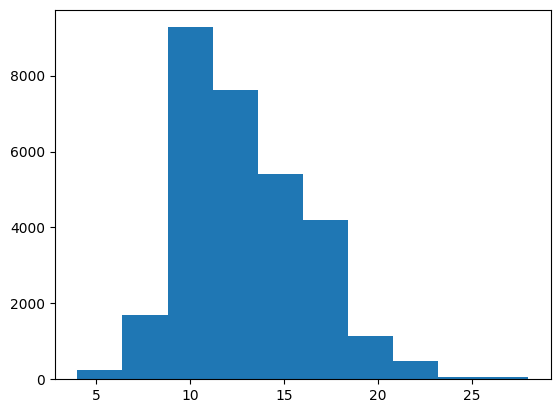

In [ ]:
plt.hist(test_df["total_lines"])

From the histogram for total number of lines we see that the most number of abstracts have close to 10 sentences with very few abstracts having more than 20 sentences. There are 99 percent of data that has 22 total line numbers.

In [ ]:
np.percentile(train_df["total_lines"], 99)

22.0

## Baseline model

Creating baseline MultinomialNB model for comparison with other DNN

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Create label encoder for NB
label_encoder = LabelEncoder()
train_label_encode = label_encoder.fit_transform(train_df["label"])
val_label_encode = label_encoder.transform(val_df["label"])
test_label_encode = label_encoder.transform(test_df["label"])

In [ ]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
pickle.dump(label_encoder, open(drive_path + "label_encoder.pkl", "wb"))

NameError: ignored

In [ ]:
!ls drive/MyDrive/model/skim

label_encoder.pkl  model_2  model_4    one_hot_encoder.pkl
model_1		   model_3  model.pkl


In [6]:
# run
label_encoder = pickle.load(open(drive_path + "label_encoder.pkl", "rb"))
train_label_encode = label_encoder.transform(train_df["label"])
val_label_encode = label_encoder.transform(val_df["label"])
test_label_encode = label_encoder.transform(test_df["label"])

In [ ]:
# Create one hot encoding for DNN
# train_label_one_hot = tf.one_hot(train_df["label"], depth = len(label_encoder.classes_))
# train_label_one_hot

# We cannot use tf one hot here as the labels are in the string format, we need to convert it to numbers first before we can use it. 

# We could have used label encoder, but dont need such kind of hierarchical approach to one hot


In [ ]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_label_one_hot = one_hot_encoder.fit_transform(train_df["label"].to_numpy().reshape(-1,1))
val_label_one_hot = one_hot_encoder.transform(val_df["label"].to_numpy().reshape(-1,1))
test_label_one_hot = one_hot_encoder.transform(test_df["label"].to_numpy().reshape(-1,1))
train_label_one_hot[:5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [ ]:
pickle.dump(one_hot_encoder, open(drive_path + "one_hot_encoder.pkl", "wb"))

In [7]:
# run
one_hot_encoder = pickle.load(open(drive_path + "one_hot_encoder.pkl", "rb"))
train_label_one_hot = one_hot_encoder.transform(train_df["label"].to_numpy().reshape(-1,1))
val_label_one_hot = one_hot_encoder.transform(val_df["label"].to_numpy().reshape(-1,1))
test_label_one_hot = one_hot_encoder.transform(test_df["label"].to_numpy().reshape(-1,1))

In [ ]:
model = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])
model.fit(train_df["text"], train_label_encode)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
pickle.dump(model, open(drive_path + "model.pkl", "wb"))

In [7]:
model = pickle.load(open(drive_path + "model.pkl", "rb"))

In [ ]:
model.score(val_df["text"], val_label_encode)

0.7218323844829869

We get 72.1 accuracy with the baseline model, which is better than the random guess.

In [8]:
# run
def get_results(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    # print(f"Accuracy: {acc}")
    # print(f"Precision: {precision}")
    # print(f"Recall: {recall}")
    # print(f"F-score: {fscore}")
    return {"accuracy": acc,
            "precision": precision,
            "recall": recall,
            "fscore": fscore}

In [ ]:
model_pred = model.predict(val_df["text"])
get_results(val_label_encode, model_pred)

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'fscore': 0.6989250353450294}

## Model 1

We will use text vectorizer and 2 bi-LSTM layers with 2 dense layers as a model. First we need to put the data in tensors for faster processing. To know the average length of the sentences that we can input to the model, let us see the length of the sentences.

In [ ]:
text_len = [len(txt.split()) for txt in train_df["text"].to_numpy()]

(array([1.25846e+05, 4.78220e+04, 5.37600e+03, 7.86000e+02, 1.46000e+02,
        3.20000e+01, 1.90000e+01, 8.00000e+00, 3.00000e+00, 2.00000e+00]),
 array([  1. ,  30.5,  60. ,  89.5, 119. , 148.5, 178. , 207.5, 237. ,
        266.5, 296. ]),
 <BarContainer object of 10 artists>)

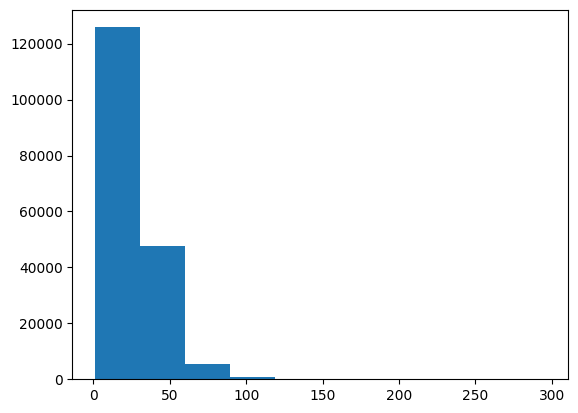

In [ ]:
plt.hist(text_len)

In [ ]:
np.percentile(text_len, 95)

55.0

The 95th percentile is length of 55 words (tokens) in a sentence. We will use that to truncate or pad our sentences.

In [ ]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = 68000, output_sequence_length = 55)
text_vectorizer.adapt(train_df["text"])

In [ ]:
# save text vectorizer
pickle.dump({"config": text_vectorizer.get_config(), "weights": text_vectorizer.get_weights()}, 
            open(drive_path + "text_vectorizer.pkl", "wb"))

In [9]:
# run
# load text vectorizer
vectorizer_pkl = pickle.load(open(drive_path + "text_vectorizer.pkl", "rb"))
text_vectorizer = tf.keras.layers.TextVectorization.from_config(vectorizer_pkl["config"])
text_vectorizer.set_weights(vectorizer_pkl["weights"])

In [10]:
# run
vocab_size = len(text_vectorizer.get_vocabulary())
vocab_size, text_vectorizer.get_vocabulary()[:10], text_vectorizer.get_vocabulary()[-10:]

(64841,
 ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were'],
 ['aarm',
  'aaqol',
  'aaq',
  'aanhui',
  'aana',
  'aainduced',
  'aaigroup',
  'aachener',
  'aachen',
  'aaacp'])

In [11]:
# run
train_ds = tf.data.Dataset.from_tensor_slices((train_df["text"].to_numpy(), train_label_one_hot))
val_ds = tf.data.Dataset.from_tensor_slices((val_df["text"].to_numpy(), val_label_one_hot))
test_ds = tf.data.Dataset.from_tensor_slices((test_df["text"].to_numpy(), test_label_one_hot))

In [12]:
train_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [13]:
# run
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.batch(32).prefetch(AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(AUTOTUNE)

In [14]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
for txt, lab in train_ds.take(1):
    print(txt)
    print(lab)

tf.Tensor(
[b'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .'
 b'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .'
 b'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .'
 b'Pain was assessed using the visual analog pain scale ( @-@ mm ) .'
 b'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .'
 b'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .'
 b'There 

There are 5627 batches

In [ ]:
train_df.shape[0] / 32

5626.25

In [ ]:
len(train_ds)

5627

Now we can create model with text vectorizer as a layer which is already adapted to the training vocab.

In [15]:
# run
embed_size = 128
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)

In [ ]:
inputs = tf.keras.Input(shape=(1, ), dtype = tf.string)
x = text_vectorizer(inputs)
x = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation = "relu")(x)
outputs = tf.keras.layers.Dense(5, activation = "softmax")(x)

model_1 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_1.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 55, 128)           8299648   
                                                                 
 bidirectional_2 (Bidirectio  (None, 55, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                           

In [ ]:
history_1 = model_1.fit(train_ds, 
                        epochs = 100,
                        validation_data = val_ds,
                        steps_per_epoch=0.1 * len(train_ds),
                        validation_steps=0.1 * len(val_ds),
                        callbacks=[early_stopping])

Epoch 1/100
562/562 [==============================] - 66s 87ms/step - loss: 0.8133 - accuracy: 0.6714 - val_loss: 0.6387 - val_accuracy: 0.7576
Epoch 2/100
562/562 [==============================] - 26s 45ms/step - loss: 0.6171 - accuracy: 0.7716 - val_loss: 0.5850 - val_accuracy: 0.7799
Epoch 3/100
562/562 [==============================] - 21s 37ms/step - loss: 0.5765 - accuracy: 0.7859 - val_loss: 0.5575 - val_accuracy: 0.7836
Epoch 4/100
562/562 [==============================] - 23s 41ms/step - loss: 0.5482 - accuracy: 0.7996 - val_loss: 0.5332 - val_accuracy: 0.7980
Epoch 5/100
562/562 [==============================] - 21s 37ms/step - loss: 0.5475 - accuracy: 0.7996 - val_loss: 0.5130 - val_accuracy: 0.8036
Epoch 6/100
562/562 [==============================] - 23s 41ms/step - loss: 0.5377 - accuracy: 0.8027 - val_loss: 0.4937 - val_accuracy: 0.8135
Epoch 7/100
562/562 [==============================] - 24s 42ms/step - loss: 0.5173 - accuracy: 0.8098 - val_loss: 0.4980 - val_ac

562/562 [==============================] - 22s 40ms/step - loss: 0.4915 - accuracy: 0.8193 - val_loss: 0.4968 - val_accuracy: 0.8174


In [ ]:
model_1.save(drive_path + "model_1")

In [16]:
# run
def plot_acc_loss(history):
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label = "Training Accuracy")
    plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
    plt.title("Accuracy vs epochs")

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label = "Training Loss")
    plt.plot(history.history["val_loss"], label = "Validation Loss")
    plt.title("Loss vs epochs")

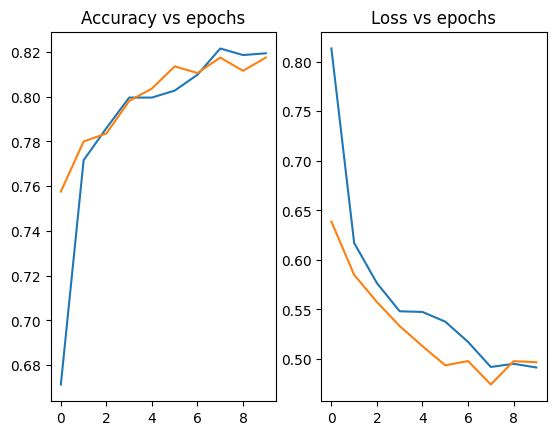

In [ ]:
plot_acc_loss(history_1)

In [17]:
model_1 = tf.keras.models.load_model(drive_path + "model_1")

In [ ]:
model_1.evaluate(val_ds)

945/945 [==============================] - 19s 10ms/step - loss: 0.4946 - accuracy: 0.8168


[0.49463409185409546, 0.8167615532875061]

In [ ]:
y_pred = model_1.predict(val_ds)
y_pred = tf.argmax(y_pred, axis=1)
get_results(val_label_encode, y_pred)

945/945 [==============================] - 10s 11ms/step


{'accuracy': 0.8167615517013107,
 'precision': 0.8186039753311407,
 'recall': 0.8167615517013107,
 'fscore': 0.8144205570142588}

## Model 2

We will build the character embedding model with similar structure as above using Bi-LSTM.

We want each token to be separated by space, so we need "H e l l o  W o r l d" for our text.

In [18]:
def get_char(txt):
    return " ".join(list(txt))

In [ ]:
train_sentences = list(train_df["text"].to_numpy())
train_chars = [get_char(i) for i in train_sentences]

val_sentences = list(val_df["text"].to_numpy())
val_chars = [get_char(i) for i in val_sentences]

test_sentences = list(test_df["text"].to_numpy())
test_chars = [get_char(i) for i in test_sentences]

In [ ]:
train_char_df = pd.DataFrame(pd.Series(train_chars), columns=["char_text"])
val_char_df = pd.DataFrame(pd.Series(val_chars), columns=["char_text"])
test_char_df = pd.DataFrame(pd.Series(test_chars), columns=["char_text"])

train_char_df.to_csv(drive_data_path + "train_char_df.csv")
val_char_df.to_csv(drive_data_path + "val_char_df.csv")
test_char_df.to_csv(drive_data_path + "test_char_df.csv")

In [17]:
# run
train_char_df = pd.read_csv(drive_data_path + "train_char_df.csv", index_col=0)
val_char_df = pd.read_csv(drive_data_path + "val_char_df.csv", index_col=0)
test_char_df = pd.read_csv(drive_data_path + "test_char_df.csv", index_col=0)

In [18]:
# run
train_char_ds = tf.data.Dataset.from_tensor_slices((train_char_df["char_text"], train_label_one_hot))
val_char_ds = tf.data.Dataset.from_tensor_slices((val_char_df["char_text"], val_label_one_hot))
test_char_ds = tf.data.Dataset.from_tensor_slices((test_char_df["char_text"], test_label_one_hot))

In [19]:
# run
train_char_ds = train_char_ds.batch(32).prefetch(AUTOTUNE)
val_char_ds = val_char_ds.batch(32).prefetch(AUTOTUNE)
test_char_ds = test_char_ds.batch(32).prefetch(AUTOTUNE)

In [22]:
train_char_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
for txt, lab in train_char_ds.take(1):
    print(txt)
    print(lab)

tf.Tensor(
[b'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .'
 b'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .'
 b'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c 

We can now have a text vectorizer to adapt to the text.

In [20]:
# run
# We need the acceptable characters in the vocabulary
char_vocab = string.ascii_lowercase + string.digits + string.punctuation
char_vocab_size = len(char_vocab) + 2
char_embed_size = 25

In [ ]:
text_len = np.array([len(txt) for txt in train_df["text"].to_numpy()])
text_len.mean()

149.3662574983337

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <BarContainer object of 10 artists>)

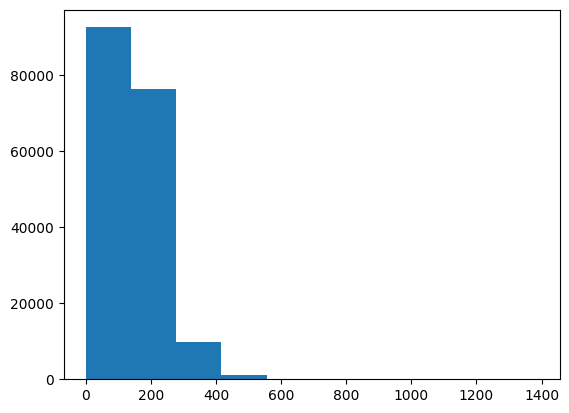

In [ ]:
plt.hist(text_len)

In [24]:
max_len = int(np.percentile(text_len, 95))
max_len

NameError: ignored

In [ ]:
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens = char_vocab_size, output_sequence_length = max_len)
char_vectorizer.adapt(train_chars)

In [ ]:
# save char vectorizer
pickle.dump({"config": char_vectorizer.get_config(), "weights": char_vectorizer.get_weights()}, 
            open(drive_path + "char_vectorizer.pkl", "wb"))

In [21]:
# run
# load char vectorizer
vectorizer_pkl = pickle.load(open(drive_path + "char_vectorizer.pkl", "rb"))
char_vectorizer = tf.keras.layers.TextVectorization.from_config(vectorizer_pkl["config"])
char_vectorizer.set_weights(vectorizer_pkl["weights"])

Creating model structure for character embedding.

In [22]:
# run
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.01,
                                                             decay_steps=1000,
                                                             decay_rate=0.96)

In [ ]:
inputs = tf.keras.Input(shape=(1, ), dtype=tf.string)
x = char_vectorizer(inputs)
x = tf.keras.layers.Embedding(input_dim=char_vocab_size, output_dim = char_embed_size, mask_zero = False)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.Dense(8, activation = "relu")(x)
outputs = tf.keras.layers.Dense(5, activation = "softmax")(x)

model_2 = tf.keras.Model(inputs = inputs, outputs = outputs)
model_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule), loss = tf.keras.losses.categorical_crossentropy, metrics = ["accuracy"])
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 55, 25)            1750      
                                                                 
 bidirectional_4 (Bidirectio  (None, 55, 32)           5376      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                           

In [ ]:
history_2 = model_2.fit(train_char_ds,
                        epochs = 100,
                        validation_data = val_char_ds,
                        steps_per_epoch = 0.1 * len(train_char_ds),
                        validation_steps = 0.1 * len(val_char_ds),
                        callbacks = [early_stopping])

Epoch 1/100
562/562 [==============================] - 34s 44ms/step - loss: 1.4105 - accuracy: 0.3724 - val_loss: 1.3131 - val_accuracy: 0.4559
Epoch 2/100
562/562 [==============================] - 24s 42ms/step - loss: 1.2342 - accuracy: 0.4785 - val_loss: 1.1076 - val_accuracy: 0.5414
Epoch 3/100
562/562 [==============================] - 23s 40ms/step - loss: 1.0851 - accuracy: 0.5445 - val_loss: 0.9610 - val_accuracy: 0.6145
Epoch 4/100
562/562 [==============================] - 21s 38ms/step - loss: 0.9153 - accuracy: 0.6337 - val_loss: 0.8526 - val_accuracy: 0.6546
Epoch 5/100
562/562 [==============================] - 24s 43ms/step - loss: 0.8671 - accuracy: 0.6604 - val_loss: 0.8321 - val_accuracy: 0.6678
Epoch 6/100
562/562 [==============================] - 23s 41ms/step - loss: 0.8361 - accuracy: 0.6777 - val_loss: 0.7998 - val_accuracy: 0.6914
Epoch 7/100
562/562 [==============================] - 24s 42ms/step - loss: 0.8028 - accuracy: 0.6844 - val_loss: 0.8181 - val_ac

562/562 [==============================] - 23s 40ms/step - loss: 0.7501 - accuracy: 0.7140 - val_loss: 0.7720 - val_accuracy: 0.7059


In [ ]:
model_2.save(drive_path + "model_2")

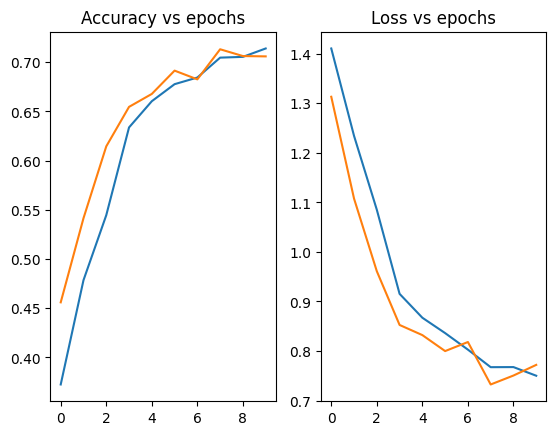

In [ ]:
plot_acc_loss(history_2)

In [ ]:
model_2 = tf.keras.models.load_model(drive_path + "model_2")

In [ ]:
model_2.evaluate(val_char_ds)

945/945 [==============================] - 17s 16ms/step - loss: 0.7117 - accuracy: 0.7294


[0.7116856575012207, 0.7294121384620667]

In [ ]:
y_pred = model_2.predict(val_char_ds)
y_pred = tf.argmax(y_pred, axis=1)
get_results(val_label_encode, y_pred)

945/945 [==============================] - 17s 16ms/step


{'accuracy': 0.7294121541109493,
 'precision': 0.7327375802131864,
 'recall': 0.7294121541109493,
 'fscore': 0.7293557576671057}

## Model 3

Using Conv1D with word embedding

In [ ]:
inputs = tf.keras.Input(shape=(1, ), dtype = tf.string)
x = text_vectorizer(inputs)
x = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True)(x)
x = tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, padding = "same", activation = "relu")(x)
x = tf.keras.layers.Conv1D(filters = 128, kernel_size = 5, activation = "relu")(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation = "relu")(x)
outputs = tf.keras.layers.Dense(5, activation = "softmax")(x)

model_3 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_3.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
model_3.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding_12 (Embedding)    (None, 55, 25)            1621025   
                                                                 
 conv1d_7 (Conv1D)           (None, 55, 64)            4864      
                                                                 
 conv1d_8 (Conv1D)           (None, 51, 128)           41088     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                         

In [ ]:
history_3 = model_3.fit(train_ds,
                        epochs = 100,
                        validation_data = val_ds,
                        steps_per_epoch = 0.1 * len(train_ds),
                        validation_steps = 0.1 * len(val_ds),
                        callbacks = [early_stopping])

Epoch 1/100
562/562 [==============================] - 61s 90ms/step - loss: 0.9247 - accuracy: 0.6212 - val_loss: 0.6633 - val_accuracy: 0.7464
Epoch 2/100
562/562 [==============================] - 11s 19ms/step - loss: 0.6530 - accuracy: 0.7526 - val_loss: 0.6033 - val_accuracy: 0.7727
Epoch 3/100
562/562 [==============================] - 7s 12ms/step - loss: 0.6148 - accuracy: 0.7699 - val_loss: 0.5772 - val_accuracy: 0.7763
Epoch 4/100
562/562 [==============================] - 4s 7ms/step - loss: 0.5753 - accuracy: 0.7853 - val_loss: 0.5578 - val_accuracy: 0.7865
Epoch 5/100
562/562 [==============================] - 6s 11ms/step - loss: 0.5716 - accuracy: 0.7889 - val_loss: 0.5423 - val_accuracy: 0.8016
Epoch 6/100
562/562 [==============================] - 7s 12ms/step - loss: 0.5601 - accuracy: 0.7917 - val_loss: 0.5456 - val_accuracy: 0.8013
Epoch 7/100
562/562 [==============================] - 5s 9ms/step - loss: 0.5353 - accuracy: 0.8006 - val_loss: 0.5117 - val_accuracy:

562/562 [==============================] - 5s 8ms/step - loss: 0.5068 - accuracy: 0.8122 - val_loss: 0.5063 - val_accuracy: 0.8109


In [ ]:
model_3.save(drive_path + "model_3")

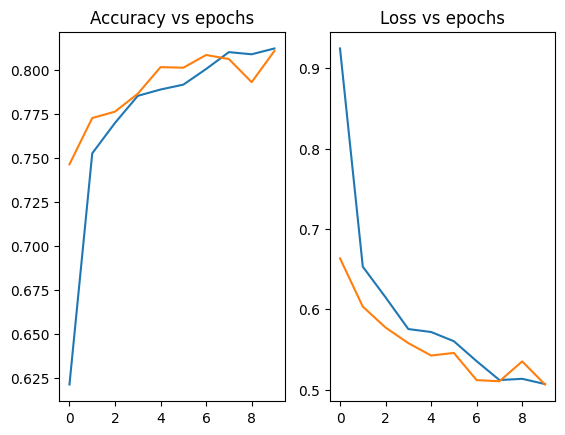

In [ ]:
plot_acc_loss(history_3)

In [ ]:
model_3 = tf.keras.models.load_model(drive_path + "model_3")

In [ ]:
model_3.evaluate(val_ds)

945/945 [==============================] - 7s 3ms/step - loss: 0.4995 - accuracy: 0.8168


[0.49946698546409607, 0.8167615532875061]

In [ ]:
y_pred = model_3.predict(val_ds)
y_pred = tf.argmax(y_pred, axis=1)
get_results(val_label_encode, y_pred)

945/945 [==============================] - 4s 4ms/step


{'accuracy': 0.8167615517013107,
 'precision': 0.8186346749005367,
 'recall': 0.8167615517013107,
 'fscore': 0.8132576024167081}

## Model 4

Using similar structure as model 3 for char embedding

In [ ]:
inputs = tf.keras.Input(shape=(1, ), dtype = tf.string)
x = char_vectorizer(inputs)
x = tf.keras.layers.Embedding(input_dim=char_vocab_size, output_dim = char_embed_size, mask_zero = False)(x)
x = tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, padding = "same", activation = "relu")(x)
x = tf.keras.layers.Conv1D(filters = 128, kernel_size = 5, activation = "relu")(x)
x = tf.keras.layers.Conv1D(filters = 256, kernel_size = 5, activation = "relu")(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation = "relu")(x)
outputs = tf.keras.layers.Dense(5, activation = "softmax")(x)

model_4 = tf.keras.Model(inputs=inputs, outputs=outputs)
model_4.compile(loss=tf.keras.losses.categorical_crossentropy, 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])
model_4.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 embedding_19 (Embedding)    (None, 290, 25)           1621025   
                                                                 
 conv1d_26 (Conv1D)          (None, 290, 64)           4864      
                                                                 
 conv1d_27 (Conv1D)          (None, 286, 128)          41088     
                                                                 
 conv1d_28 (Conv1D)          (None, 282, 256)          164096    
                                                          

In [ ]:
history_4 = model_4.fit(train_char_ds,
                        epochs = 100,
                        validation_data = val_char_ds,
                        steps_per_epoch = 0.1 * len(train_char_ds),
                        validation_steps = 0.1 * len(val_char_ds),
                        callbacks = [early_stopping])

Epoch 1/100
562/562 [==============================] - 9s 12ms/step - loss: 1.1994 - accuracy: 0.4813 - val_loss: 1.0132 - val_accuracy: 0.5668
Epoch 2/100
562/562 [==============================] - 6s 10ms/step - loss: 0.9191 - accuracy: 0.6289 - val_loss: 0.8011 - val_accuracy: 0.6829
Epoch 3/100
562/562 [==============================] - 5s 10ms/step - loss: 0.8203 - accuracy: 0.6776 - val_loss: 0.7411 - val_accuracy: 0.7030
Epoch 4/100
562/562 [==============================] - 6s 11ms/step - loss: 0.7576 - accuracy: 0.7075 - val_loss: 0.7349 - val_accuracy: 0.7181
Epoch 5/100
562/562 [==============================] - 6s 10ms/step - loss: 0.7236 - accuracy: 0.7219 - val_loss: 0.6486 - val_accuracy: 0.7539
Epoch 6/100
562/562 [==============================] - 6s 11ms/step - loss: 0.7006 - accuracy: 0.7330 - val_loss: 0.6409 - val_accuracy: 0.7579
Epoch 7/100
562/562 [==============================] - 5s 10ms/step - loss: 0.6740 - accuracy: 0.7422 - val_loss: 0.6229 - val_accuracy:

562/562 [==============================] - 6s 10ms/step - loss: 0.6305 - accuracy: 0.7620 - val_loss: 0.6423 - val_accuracy: 0.7546


In [ ]:
model_4.save(drive_path + "model_4")

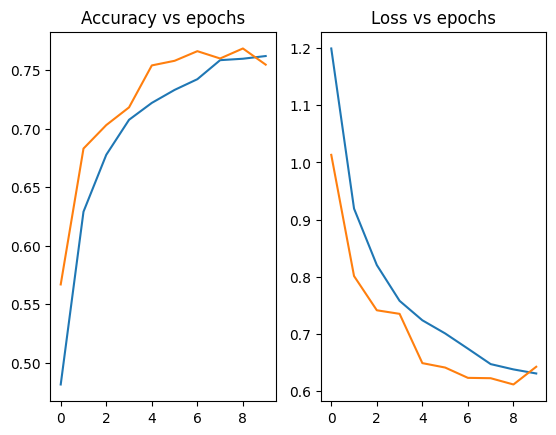

In [ ]:
plot_acc_loss(history_4)

In [ ]:
model_4 = tf.keras.models.load_model(drive_path + "model_4")

In [ ]:
model_4.evaluate(val_char_ds)

945/945 [==============================] - 5s 5ms/step - loss: 0.6417 - accuracy: 0.7580


[0.6416757106781006, 0.7579769492149353]

In [ ]:
y_pred = model_4.predict(val_char_ds)
y_pred = tf.argmax(y_pred, axis=1)
get_results(val_label_encode, y_pred)

945/945 [==============================] - 4s 4ms/step


{'accuracy': 0.7579769627962399,
 'precision': 0.7539797846882453,
 'recall': 0.7579769627962399,
 'fscore': 0.7507594619254448}

## Model 5

Creating model taking reference from the paper:

[Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/abs/1612.05251)

Using PubMed 20k RCT dataset as from the following paper:

[PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071)

We observe that the ANN models previously experimented by us are approximately closer to 86% accuracy from the paper. Now we plan to use the model architecture which combines the char embedding, word embedding and the line numbers features. The paper uses the model architecture with label sequence optimization layer, but we will be concatenating another input such that it will contain the line numbers as input to make up for the missing layer at the end. (Learn the pattern rather than use the formula given for final scores).

In [23]:
import gc
gc.collect()

0

In [24]:
gc.get_count()

(90, 0, 0)

### Preparing data

(array([4.5000e+04, 4.4941e+04, 4.2383e+04, 2.9914e+04, 1.2840e+04,
        3.8000e+03, 9.1000e+02, 2.0000e+02, 4.3000e+01, 9.0000e+00]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <BarContainer object of 10 artists>)

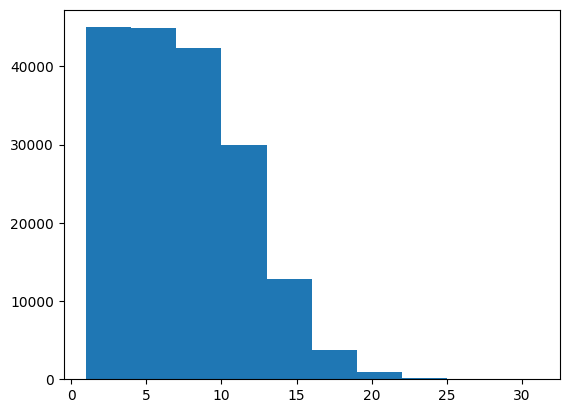

In [ ]:
plt.hist(train_df["line_number"])

(array([ 1393., 23102., 67507., 40551., 32807., 11026.,  2051.,  1223.,
          291.,    89.]),
 array([ 4. ,  6.7,  9.4, 12.1, 14.8, 17.5, 20.2, 22.9, 25.6, 28.3, 31. ]),
 <BarContainer object of 10 artists>)

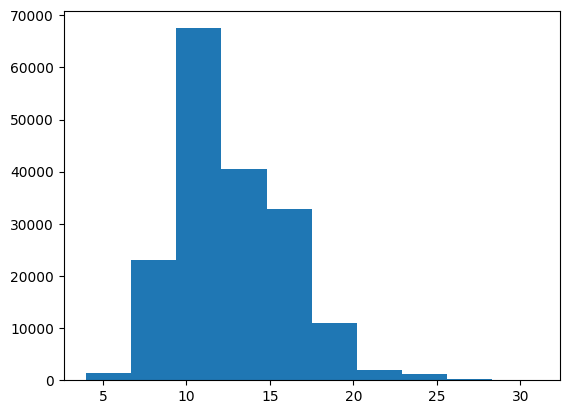

In [ ]:
plt.hist(train_df["total_lines"])

In [ ]:
max_line_number = np.percentile(train_df["line_number"], 99)
max_line_number

18.0

In [ ]:
max_total_lines = np.percentile(train_df["total_lines"], 99)
max_total_lines

22.0

As the line numbers are already numerical, we can use them directly in our dataset

In [25]:
train_ds_all = tf.data.Dataset.from_tensor_slices((train_char_df["char_text"], 
                                                   train_df["text"], 
                                                   train_df["line_number"], 
                                                   train_df["total_lines"]))
val_ds_all = tf.data.Dataset.from_tensor_slices((val_char_df["char_text"], 
                                                 val_df["text"], 
                                                 val_df["line_number"], 
                                                 val_df["total_lines"]))
test_ds_all = tf.data.Dataset.from_tensor_slices((test_char_df["char_text"], 
                                                  test_df["text"], 
                                                  test_df["line_number"], 
                                                  test_df["total_lines"]))

train_ds_lab = tf.data.Dataset.from_tensor_slices((train_label_one_hot))
val_ds_lab = tf.data.Dataset.from_tensor_slices((val_label_one_hot))
test_ds_lab = tf.data.Dataset.from_tensor_slices((test_label_one_hot))

train_ds_all = tf.data.Dataset.zip((train_ds_all, train_ds_lab))
val_ds_all = tf.data.Dataset.zip((val_ds_all, val_ds_lab))
test_ds_all = tf.data.Dataset.zip((test_ds_all, test_ds_lab))

train_ds_all = train_ds_all.batch(32).prefetch(AUTOTUNE)
val_ds_all = val_ds_all.batch(32).prefetch(AUTOTUNE)
test_ds_all = test_ds_all.batch(32).prefetch(AUTOTUNE)

In [ ]:
for txt, lab in train_ds_all.take(1):
    print(txt)
    print(lab)

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .',
       b'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
       b'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n 

### Preparing model

In [26]:
class Gc_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
gc_callback = Gc_callback()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.01,
                                                             decay_steps=2000,
                                                             decay_rate=0.5)

In [25]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy()

In [37]:
# with strategy.scope():

inputs = tf.keras.Input(shape = (1,), dtype = tf.string, name = "token_model_input")
x = text_vectorizer(inputs)

outputs = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero = False)(x)

# x = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero = False)(x)
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
# outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True))(x)

# outputs = tf.keras.layers.Conv1D(filters = 128, kernel_size = 3, padding = "same", activation = "relu")(x)

token_model = tf.keras.Model(inputs = inputs, outputs = outputs)

inputs = tf.keras.Input(shape = (1,), dtype = tf.string, name = "char_model_input")
x = char_vectorizer(inputs)
x = tf.keras.layers.Embedding(input_dim=char_vocab_size, output_dim = char_embed_size, mask_zero = False)(x)

# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True))(x)
# outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True))(x)

# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True))(x)
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True))(x)
# outputs = tf.keras.layers.Conv1D(filters = 16, kernel_size = 3, padding = "same", activation = "relu")(x)

x = tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, padding = "same", activation = "relu")(x)
outputs = tf.keras.layers.Conv1D(filters = 128, kernel_size = 5, padding = "same", activation = "relu")(x)

# outputs = tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, padding = "same", activation = "relu")(x)

char_model = tf.keras.Model(inputs = inputs, outputs = outputs)

#concatenate model

char_token_embed = tf.keras.layers.Concatenate(name = "concatenate_char_token")([char_model.output, token_model.output])

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True))(char_token_embed)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)

# add line number feature
inputs = tf.keras.Input(shape = (1), name = "line_number_input")
outputs = tf.keras.layers.Dense(10, activation = "relu")(inputs)
line_model = tf.keras.Model(inputs = inputs, outputs = outputs)

# add total line feature
inputs = tf.keras.Input(shape = (1), name = "total_line_input")
outputs = tf.keras.layers.Dense(10, activation = "relu")(inputs)
total_model = tf.keras.Model(inputs = inputs, outputs = outputs)

x = tf.keras.layers.Concatenate(name = "concatenate_all_input")([x, line_model.output, total_model.output])

x = tf.keras.layers.Dense(32, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(5, activation = "softmax", name="output_layer")(x)

model_5 = tf.keras.Model(inputs = [char_model.input, token_model.input, line_model.input, total_model.input],
                        outputs = outputs,
                        name = "model_5")
model_5.compile(optimizer = tf.keras.optimizers.Adam(lr_schedule), 
                loss = tf.keras.losses.categorical_crossentropy, 
                metrics = ["accuracy"])

model_5.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_model_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 55)          0           ['char_model_input[0][0]']       
 orization)                                                                                       
                                                                                                  
 embedding_9 (Embedding)        (None, 55, 25)       1750        ['text_vectorization_1[4][0]']   
                                                                                                  
 token_model_input (InputLayer)  [(None, 1)]         0           []                         

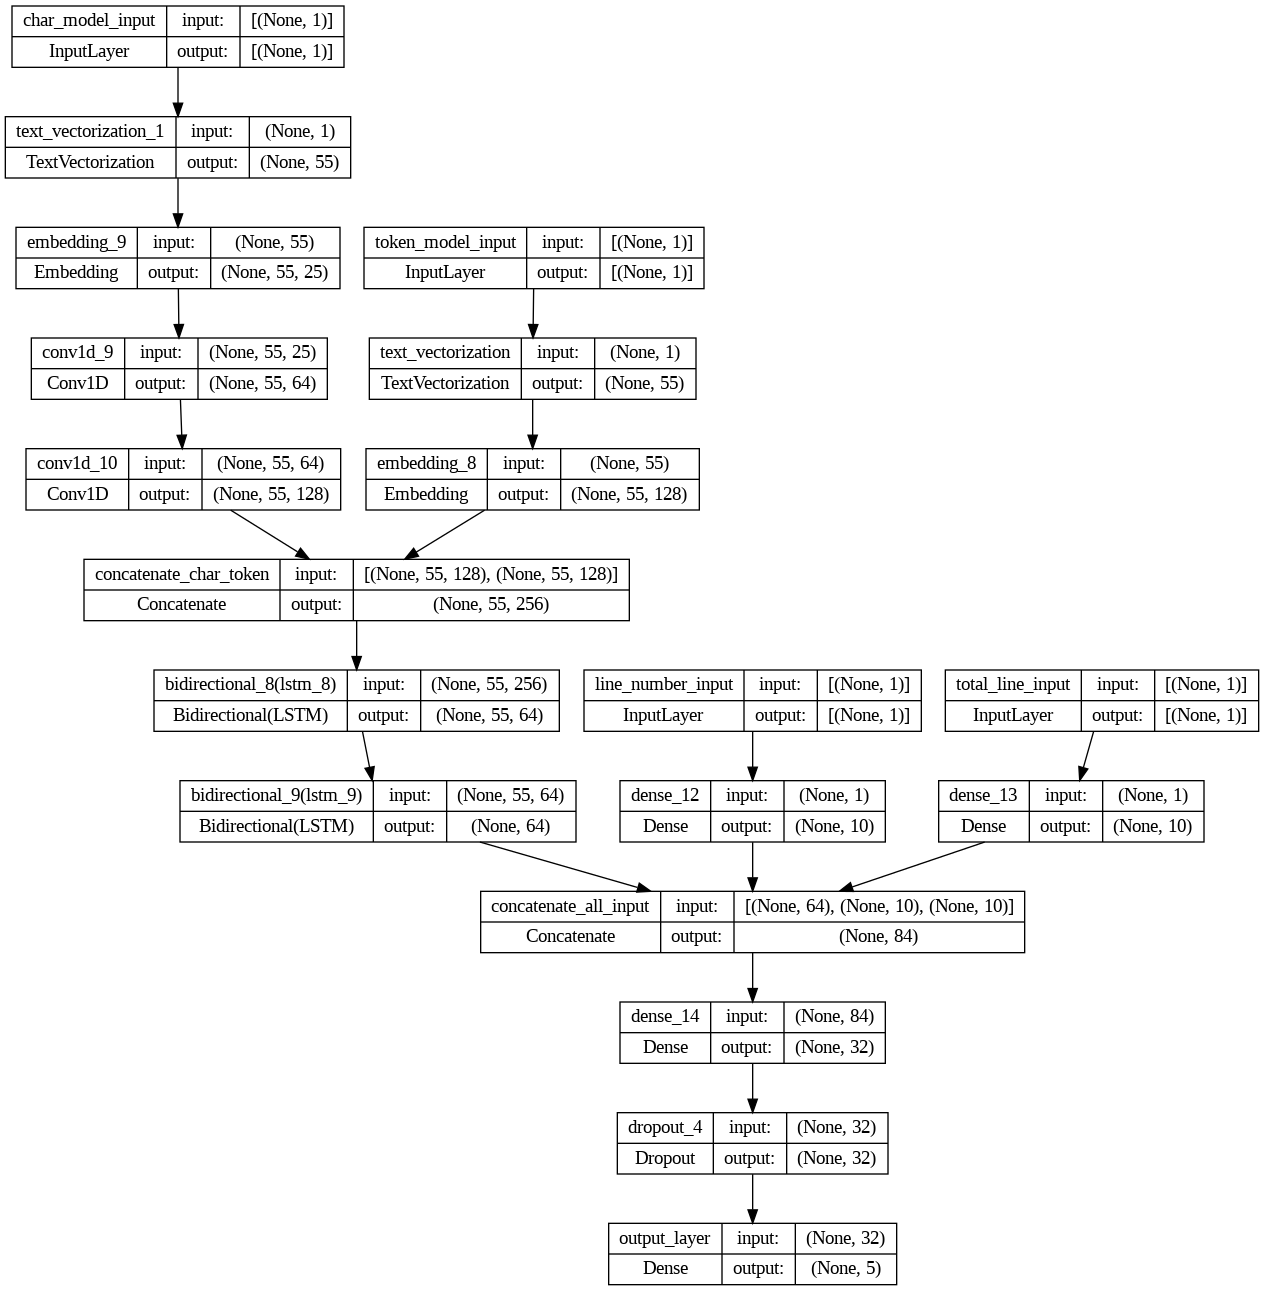

In [38]:
tf.keras.utils.plot_model(model_5, show_shapes = True)

In [39]:
train_ds_all_repeat = train_ds_all.repeat()
history_5 = model_5.fit(train_ds_all_repeat,
                        validation_data = val_ds_all,
                        steps_per_epoch = 0.5 * len(train_ds_all),
                        # validation_steps = 0.1 * len(val_ds_all),
                        epochs = 100,
                        callbacks = [early_stopping, gc_callback])

Epoch 1/100
2813/2813 [==============================] - 102s 33ms/step - loss: 0.8448 - accuracy: 0.6432 - val_loss: 0.4640 - val_accuracy: 0.8275
Epoch 2/100
2813/2813 [==============================] - 66s 24ms/step - loss: 0.5980 - accuracy: 0.7789 - val_loss: 0.3621 - val_accuracy: 0.8687
Epoch 3/100
2813/2813 [==============================] - 61s 22ms/step - loss: 0.5053 - accuracy: 0.8216 - val_loss: 0.3452 - val_accuracy: 0.8765
Epoch 4/100
2813/2813 [==============================] - 62s 22ms/step - loss: 0.4772 - accuracy: 0.8316 - val_loss: 0.3452 - val_accuracy: 0.8750
Epoch 5/100
2813/2813 [==============================] - 60s 21ms/step - loss: 0.4554 - accuracy: 0.8404 - val_loss: 0.3450 - val_accuracy: 0.8799
Epoch 6/100
2813/2813 [==============================] - 63s 22ms/step - loss: 0.4551 - accuracy: 0.8416 - val_loss: 0.3454 - val_accuracy: 0.8794
Epoch 7/100
2813/2813 [==============================] - 61s 22ms/step - loss: 0.4444 - accuracy: 0.8440 - val_loss: 

In [40]:
model_5.save(drive_path + "model_5")

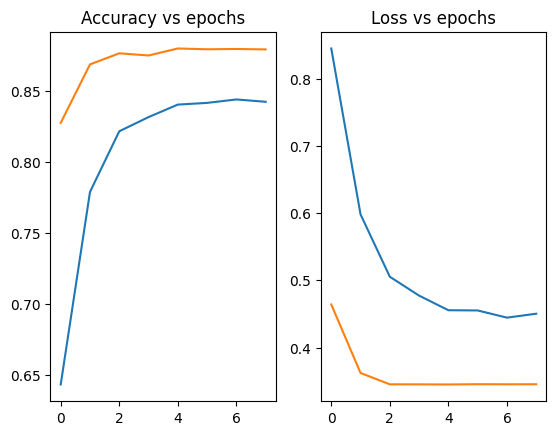

In [41]:
plot_acc_loss(history_5)

In [ ]:
model_5 = tf.keras.models.load_model(drive_path + "model_5")

In [42]:
model_5.evaluate(val_ds_all)

945/945 [==============================] - 9s 9ms/step - loss: 0.3450 - accuracy: 0.8799


[0.3449901044368744, 0.8799483776092529]

In [43]:
y_pred = model_5.predict(val_ds_all)
y_pred = tf.argmax(y_pred, axis=1)
get_results(val_label_encode, y_pred)

945/945 [==============================] - 10s 9ms/step


{'accuracy': 0.8799483648881239,
 'precision': 0.8858098147852594,
 'recall': 0.8799483648881239,
 'fscore': 0.8759580918992527}

In [44]:
y_pred = model_5.predict(test_ds_all)
y_pred = tf.argmax(y_pred, axis=1)
get_results(test_label_encode, y_pred)

942/942 [==============================] - 8s 9ms/step


{'accuracy': 0.8739007798241247,
 'precision': 0.8773999905793132,
 'recall': 0.8739007798241247,
 'fscore': 0.8694359346360101}